In [2]:
#Imports
import os
import pickle
import random
import numpy as np
import shutil
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from argparse import Namespace
import torch.nn as nn
import torch
from torch import linalg as LA
import wandb
import logging
from pytorch_lightning.loggers import CSVLogger, TensorBoardLogger, WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import os

logger = logging.getLogger(__name__)
#wandb_logger = lambda dir, version: WandbLogger(
 #   name="wandb", save_dir=dir, version=version
#)
def wandb_logger(dir,version,name):
    return WandbLogger(
    name=name, save_dir=dir, version=version
)
csvlogger = lambda dir, version: CSVLogger(dir, name="csvlogs", version=version)
tblogger = lambda dir, version: TensorBoardLogger(dir, name="tblogs", version=version)

def get_loggers(dir,version,name,lis=["csv"]):
    lgrs = []
    if "wandb" in lis:
        lgrs.append(wandb_logger(dir, version))
    if "csv" in lis:
        lgrs.append(csvlogger(dir, version))
    if "tb" in lis:
        lgrs.append(tblogger(dir, version))
    return lgrs

#global vars
DATA_DIR = '/common/home/vk405/Projects/Crossmdl/Data/Recipe/'
EMB_TRN = DATA_DIR+'embeddings_train1.pkl'
EMB_VAL = DATA_DIR+'embeddings_val1.pkl'
ING_TRN = DATA_DIR+'ingredients_embeddings_train.pkl'
ING_VAL = DATA_DIR+'ingredients_embeddings_val.pkl'
#os.listdir(DATA_DIR)

/common/home/vk405/miniconda3/envs/Crossmdl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
# Dataset
class RecipeDset(Dataset):
    def __init__(self,data_dir= '/common/home/vk405/Projects/Crossmdl/Data/Recipe/'\
        ,split='train',txt_emb_type='total'):
        self.DATA_DIR = data_dir
        self.init_data_locs()
        self.txt_emb_type = txt_emb_type
        self.split = split
        if self.txt_emb_type == 'total':
            if self.split == 'train':
                with open(self.EMB_TRN, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)
            elif self.split == 'valid':
                with open(self.EMB_VAL, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)
            elif self.split == 'test':
                with open(self.EMB_TST, 'rb') as files:
                    self.emb_vid,self.emb_txt,self.ids = pickle.load(files)


    def __getitem__(self,idx):
        rind = idx+1
        if rind == len(self.emb_txt):
            rind = idx-1
        return self.emb_vid[idx],self.emb_txt[idx],self.emb_vid[rind]

    def __len__(self):
        return len(self.emb_txt)

    def init_data_locs(self):
        #TOTAL EMBEDDINGS
        self.EMB_TRN = self.DATA_DIR+'embeddings_train1.pkl'
        self.EMB_VAL = self.DATA_DIR+'embeddings_val1.pkl'
        self.EMB_TST = self.DATA_DIR+'embeddings_test1.pkl'
        #INGRIDIENTS Embeddings
        self.ING_TRN = self.DATA_DIR+'ingredients_embeddings_train.pkl'
        self.ING_VAL = self.DATA_DIR+'ingredients_embeddings_val.pkl'
        self.ING_TST = self.DATA_DIR + 'ingredients_embeddings_test.pkl'

        #TITLE EMBEDDINGS
        self.TIT_TRN = self.DATA_DIR+'title_embeddings_train.pkl'
        self.TIT_VAL = self.DATA_DIR+'title_embeddings_val.pkl'
        self.TIT_TST = self.DATA_DIR + 'title_embeddings_test.pkl'

        #Instructions
        self.INS_TRN = self.DATA_DIR+'instructions_embeddings_train.pkl'
        self.INS_VAL = self.DATA_DIR+'instructions_embeddings_val.pkl'
        self.INS_TST = self.DATA_DIR+'instructions_embeddings_test.pkl'


        











# Model
class EmbModel(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.params = params
        self.lyrs = []
        dim = self.params['input_dim']
        for i in range(self.params['lyrs']):
            if "emb_dim" not in self.params:
                lyr = nn.Linear(dim,dim)
            else:
                prev_dim = dim
                out_dim = self.params['emb_dim'][i]
                if i>0:
                    prev_dim = self.params['emb_dim'][i-1]
                lyr = nn.Linear(prev_dim,out_dim)
            if self.params['act'] == 'relu':
                non_lin = nn.ReLU()
            else:
                raise NotImplementedError
            self.lyrs.append(lyr)
            self.lyrs.append(non_lin)
        self.feedforward = nn.Sequential(*self.lyrs)
    def forward(self,x):
        return self.feedforward(x)





class RecipeModel(pl.LightningModule):
    def __init__(self,hparams):
        super().__init__()
        self.save_hyperparameters(hparams)
        #import pdb;pdb.set_trace()
        self.txt_emb = EmbModel(self.hparams.txt_model)
        self.img_emb = EmbModel(self.hparams.img_model)
        self.shared = nn.Linear(self.hparams.txt_model['fin_dim'],\
            self.hparams.shared_emb_dim)
    def forward(self,x):
        # Ignores anchor embedding
        img,txt = x
        img_emb = self.img_emb(img)
        txt_emb = self.txt_emb(txt)
        #anch_img_emb = self.img_emb(anch_img)

        img_fin_emb = self.shared(img_emb)
        txt_fin_emb = self.shared(txt_emb)
        #anch_img_fin_emb = self.shared(anch_img_emb)
        return img_fin_emb,txt_fin_emb

    def training_step(self,batch,batch_idx):
        img,txt,anch_img = batch
        anch_img_emb = self.img_emb(anch_img)
        anch_img_fin_emb = self.shared(anch_img_emb)
        img_fin_emb,txt_fin_emb = self((img,txt))
        loss,log_losses = self.get_loss(img_fin_emb,txt_fin_emb,anch_img_fin_emb)
        self.log("train_loss",loss,on_step=True)
        self.log("cos_sim_n",log_losses[0],on_step=True)
        self.log("cos_sim_p",log_losses[-1],on_step=True)

        return loss

    def validation_step(self,batch,batch_idx):
        img,txt,anch_img = batch
        anch_img_emb = self.img_emb(anch_img)
        anch_img_fin_emb = self.shared(anch_img_emb)
        img_fin_emb,txt_fin_emb = self((img,txt))
        loss,log_losses = self.get_loss(img_fin_emb,txt_fin_emb,anch_img_fin_emb)
        #collects batchwise stats for rank over half of batchsize
        sz = int(img_fin_emb.shape[0]//2)
        median,recall = self.rank('image',img_fin_emb.detach().cpu().numpy(),txt_fin_emb.detach().cpu().numpy(),sz)

        self.log("val_loss",loss,on_step=False, on_epoch=True)
        self.log("val_cos_sim_n",log_losses[0],on_step=False, on_epoch=True)
        self.log("val_cos_sim_p",log_losses[-1],on_step=False, on_epoch=True)
        # main metrics
        self.log("val_medianrank",median,on_step=False, on_epoch=True)
        self.log("val_recall_1",recall[1],on_step=False, on_epoch=True)
        self.log("val_recall_5",recall[5],on_step=False, on_epoch=True)
        self.log("val_recall_10",recall[10],on_step=False, on_epoch=True)
        return loss

    # inference code

    def get_loss(self,img,txt,anch,reduce='mean'):
        #𝐿𝑐𝑜𝑠(𝒂,𝒑,𝒏)=max[𝑑(𝒂,𝒏)−𝑑(𝒂,𝒑)+𝜖,0]
        eps = self.hparams.eps if 'eps' in self.hparams else 1e-8
        
        im_norm,txt_norm,anch_norm = LA.norm(img,dim=-1).reshape(img.shape[0],1),\
        LA.norm(txt,dim=-1).reshape(txt.shape[0],1),LA.norm(anch,dim=-1).reshape(anch.shape[0],1)
        normd_img = img/im_norm
        normd_txt = txt/txt_norm
        normd_anch = anch/anch_norm

        cos_sim_p = torch.sum(normd_img*normd_txt,dim=-1)
        cos_sim_n = torch.sum(normd_anch*normd_txt,dim=-1)

        unclipped_loss = cos_sim_n-cos_sim_p+eps
        clipped_loss = torch.relu(unclipped_loss)
        if reduce == 'mean':
            return torch.mean(clipped_loss),(torch.mean(cos_sim_n),torch.mean(cos_sim_p))

    def configure_optimizers(self):
        lr = self.hparams.lr if 'lr' in self.hparams else 1e-3
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer

    def rank(self,type_embedding , img_embeds, rec_embeds, samples):
        random.seed(42)
        im_vecs = img_embeds 
        instr_vecs = rec_embeds 


        # Sort based on names to always pick same samples for medr
    #     idxs = np.argsort(names)
    #     names = names[idxs]

        # Ranker
        N = samples
        idxs = range(N)
        
        glob_rank = []
        glob_recall = {1:0.0,5:0.0,10:0.0}
        for i in range(10):

            ids = random.sample(range(0,len(img_embeds)), N)
            im_sub = im_vecs[ids,:]
            instr_sub = instr_vecs[ids,:]
    #         ids_sub = names[ids]

            # if params.embedding == 'image':
            if type_embedding == 'image':
                sims = np.dot(im_sub,instr_sub.T) # for im2recipe
            else:
                sims = np.dot(instr_sub,im_sub.T) # for recipe2im

            med_rank = []
            recall = {1:0.0,5:0.0,10:0.0}

            for ii in idxs:

    #             name = ids_sub[ii]
                # get a column of similarities
                sim = sims[ii,:]

                # sort indices in descending order
                sorting = np.argsort(sim)[::-1].tolist()

                # find where the index of the pair sample ended up in the sorting
                pos = sorting.index(ii)

                if (pos+1) == 1:
                    recall[1]+=1
                if (pos+1) <=5:
                    recall[5]+=1
                if (pos+1)<=10:
                    recall[10]+=1

                # store the position
                med_rank.append(pos+1)

            for i in recall.keys():
                recall[i]=recall[i]/N

            med = np.median(med_rank)
            # print "median", med

            for i in recall.keys():
                glob_recall[i]+=recall[i]
            glob_rank.append(med)

        for i in glob_recall.keys():
            glob_recall[i] = glob_recall[i]/10

        return np.average(glob_rank), glob_recall




        

In [24]:
#cfg corresponding to best model

#eps = eps = 0.1
cfg = Namespace(
    seed = 0,
    version = 'retrievallyr_1',
    artifacts_loc = "/common/home/vk405/Projects/Crossmdl/nbs/Recipe/",
    data_dir = "/common/home/vk405/Projects/Crossmdl/Data/Recipe/",
    mode = 'train',
    txt_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    img_model = {'input_dim':1024,'lyrs':1,'fin_dim':1024,'act':'relu'},
    shared_emb_dim = 1024,
    txt_emb_type = 'total',
    lr = 1e-4,
    eps = 0.5,
    loggers = ["csv"],
    cbs = ["checkpoint","early_stop"],
    trainer = {'log_every_n_steps': 50,
    'max_epochs': 10},
    checkpoint = {"every_n_epochs": 1,
    "monitor": "val_recall_1"},
    early_stop = {"monitor":"val_recall_1","patience":2,"mode":'max'},
    batch_size=512,
    val_batch_size = 2000


)

In [25]:
log_dir = '/common/home/vk405/Projects/Crossmdl/nbs/Recipe/'
ckpt_dir = log_dir+'ckpts/'+cfg.version+'/'
ckpt = ckpt_dir+os.listdir(ckpt_dir)[0]
ckpt


'/common/home/vk405/Projects/Crossmdl/nbs/Recipe/ckpts/retrievallyr_1/epoch=2-val_recall_1=0.54.ckpt'

In [36]:


recipedata_test = RecipeDset(data_dir=cfg.data_dir,split='test',\
            txt_emb_type = cfg.txt_emb_type)

test_loader = DataLoader(recipedata_test,batch_size=1000,shuffle=False)
net = RecipeModel(cfg)

In [37]:
model = net.load_from_checkpoint(ckpt)

In [32]:
#batch = next(iter(test_loader))

In [38]:
img_emb_list = []
txt_emb_list = []

with torch.no_grad():
    for batch in test_loader:
        img,txt,_ = batch
        img_emb,txt_emb = model((img,txt))
        img_emb_list.append(img_emb)
        txt_emb_list.append(txt_emb)

    
    

In [44]:
tst_img_emb = np.concatenate(img_emb_list)
tst_txt_emb = np.concatenate(txt_emb_list)

In [45]:
median,recall = model.rank('image',tst_img_emb,tst_txt_emb,1000)

print("1K Samples:")
print(median,recall)
print("*"*30)

1K Samples:
1.0 {1: 0.54, 5: 0.8200999999999998, 10: 0.8886000000000001}
******************************


In [46]:
median,recall = model.rank('image',tst_img_emb,tst_txt_emb,10000)

print("10K Samples:")
print(median,recall)
print("*"*30)

10K Samples:
5.85 {1: 0.22646000000000002, 5: 0.49429, 10: 0.61405}
******************************


In [23]:
#csv logs

log_dir = '/common/home/vk405/Projects/Crossmdl/nbs/Recipe/'
import pandas as pd
df = pd.read_csv(log_dir+'csvlogs/retrievaleps_0.5/metrics.csv')
df2 = pd.read_csv(log_dir+'csvlogs/retrievaleps_0.3/metrics.csv')

In [27]:
df['val_recall_1'].dropna().iloc[-1]

0.4995366632938385

In [31]:
log_dir = '/common/home/vk405/Projects/Crossmdl/nbs/Recipe/csvlogs/'
import os
dirs = os.listdir(log_dir)

for dir in dirs:
    file = log_dir+dir+'/'+'metrics.csv'
    print(f"dir:{dir}")
    df = pd.read_csv(file)
    if dir not in ['retrieval','temp']:
        print(df['val_recall_1'].dropna().iloc[-1])

dir:retrievaleps_1.5
0.0118830883875489
dir:retrievaleps_0.5
0.4995366632938385
dir:retrievalINSlyr_1
0.2895468473434448
dir:retrievalhiddim_256
0.5200059413909912
dir:retrievalhiddim_512
0.5344774723052979
dir:retrievalMSElyr_1
0.0006222898955456
dir:retrievallyr_4
0.2205686867237091
dir:retrievaleps_0.1
0.4291946589946747
dir:retrievaleps_1.1
0.0625169649720192
dir:retrievallyr_3
0.4378637075424194
dir:retrievalINGlyr_1
0.290066510438919
dir:temp
dir:retrievalhiddim_2048
0.5330873131752014
dir:retrievaleps_1.3
0.0305418577045202
dir:retrievaleps_0.5_defaultbest
0.4683790802955627
dir:retrievallyr_1
0.5373440384864807
dir:retrievaleps_0.9
0.2053986936807632
dir:retrievaleps_0.3
0.5049716830253601
dir:retrievalTITlyr_1
0.1439674198627472
dir:retrievaleps_0.7
0.4124027788639068
dir:retrieval


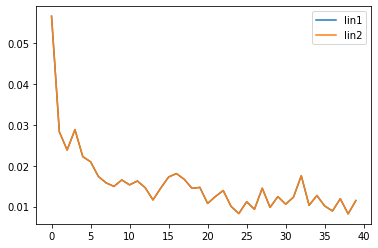

In [22]:
import matplotlib.pyplot as plt

plt.plot(list(range(40)),e['train_loss'][:40],label='lin1')
plt.plot(list(range(40)),f['train_loss'][:40],label='lin2')
plt.legend()
plt.show()


## TODO: 

1.Plot traninig plots for all the hyperparam experiments - train-loss, cos-sim,sin-sim.

2.Show comparision stats on test set for [total,title,ingredients,instruction models].

3.Show retrieved images

4. Plot how smooth interpolation between images retrieve interpolated text too.
